In [1]:
import numpy as np
import numexpr as ne
from numba import jit,prange
import matplotlib.pyplot as plt

In [2]:
'''
Exact propagation in 2D. 
'''
@jit(nopython=True, parallel=True)
def exact_prop_2D(in_wave,out_wave,L_in,L_out,wavel,z):
    pi = np.pi
    N_in_x = in_wave.shape[0]
    N_in_y = in_wave.shape[1]
    in_domain_x = np.linspace(-L_in/2,L_in/2,N_in_x)
    in_domain_y = np.linspace(-L_in/2,L_in/2,N_in_y)
    
    N_out_x = out_wave.shape[0]
    N_out_y = out_wave.shape[1]
    out_domain_x = np.linspace(-L_out/2,L_out/2,N_out_x)
    out_domain_y = np.linspace(-L_out/2,L_out/2,N_out_y)
    
    step_in_x = L_in/N_in_x
    step_in_y = L_in/N_in_y
    for i in range(N_out_x):
        for j in range(N_out_y):
            for p in range(N_in_x):
                for q in range(N_in_y):
                    x  =  in_domain_x[p]
                    y  =  in_domain_y[q]
                    x1 = out_domain_x[i]
                    y1 = out_domain_y[j]
                    f  = in_wave[p][q]
                    out_wave[i][j] += f*np.exp(((-1j*pi)/(wavel*z))*((x-x1)**2+(y-y1)**2))
    out_wave *= ((1/np.sqrt(1j*wavel*z))*step_in_x)
    return

In [3]:
wavel = 0.5*10**(-6)
pi = np.pi
z = 100
N = 500
L_in  = 5e-1

in_wave = np.zeros((N,N))
in_wave[int(N/2)-int(N/8):int(N/2)+int(N/8),int(N/2)-int(N/8):int(N/2)+int(N/8)] = 1
out_wave_exact = np.zeros((N,N),dtype='complex128')

In [4]:
exact_prop_2D(in_wave,out_wave_exact,L_in,L_in,wavel,z)

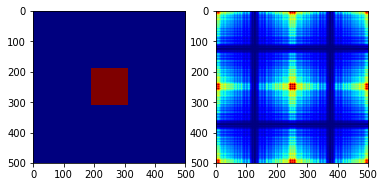

In [5]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(in_wave,cmap='jet')
ax2.imshow(np.abs(out_wave_exact),cmap='jet')
plt.show()